In [119]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
import glob
from pathlib import Path

In [120]:
GESTURES = [
    # "done",
    # "hi",
    # "love",
    # "good",
    "how",
    "me",
    # "sorry",
    "bus",
    "you",
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv(gesture + "_tgt.csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 1000) / 2000,
          (df['gY'][index] + 1000) / 2000,
          (df['gZ'][index] + 1000) / 2000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

Processing index 0 for gesture 'how'.
	There are 75 recordings of the how gesture.
Processing index 1 for gesture 'me'.
	There are 75 recordings of the me gesture.
Processing index 2 for gesture 'bus'.
	There are 75 recordings of the bus gesture.
Processing index 3 for gesture 'you'.
	There are 75 recordings of the you gesture.


In [121]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

print(num_inputs)
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)
print("TRAIN_SIZE: " , TRAIN_SPLIT ," ", TRAIN_SPLIT/num_inputs)
print("TEST_SIZE: " , TEST_SPLIT ," ", TEST_SPLIT/num_inputs)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

300
TRAIN_SIZE:  180   0.6
TEST_SIZE:  240   0.8


In [122]:
print(inputs_train.shape)
print(inputs_test.shape)
print(inputs_validate.shape)

(180, 714)
(60, 714)
(60, 714)


In [123]:
from tensorflow.keras.callbacks import Callback
class epoch_progress(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch+1)%50 == 0:
            print("epoch {} is done".format(epoch+1))

In [124]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(32, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [125]:
ep = epoch_progress()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
history_1 = model.fit(inputs_train, outputs_train, 
                    epochs=200, 
                    batch_size=1, 
                    verbose=0,
                    use_multiprocessing=True,
                    # callbacks = [ep],
                    callbacks = [ep, callback],
                    validation_data=(inputs_test, outputs_test))

epoch 50 is done
epoch 100 is done
epoch 150 is done
epoch 200 is done


In [126]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (1, 64)                   45760     
                                                                 
 dense_37 (Dense)            (1, 64)                   4160      
                                                                 
 dense_38 (Dense)            (1, 32)                   2080      
                                                                 
 dense_39 (Dense)            (1, 32)                   1056      
                                                                 
 dense_40 (Dense)            (1, 4)                    132       
                                                                 
Total params: 53,188
Trainable params: 53,188
Non-trainable params: 0
_________________________________________________________________


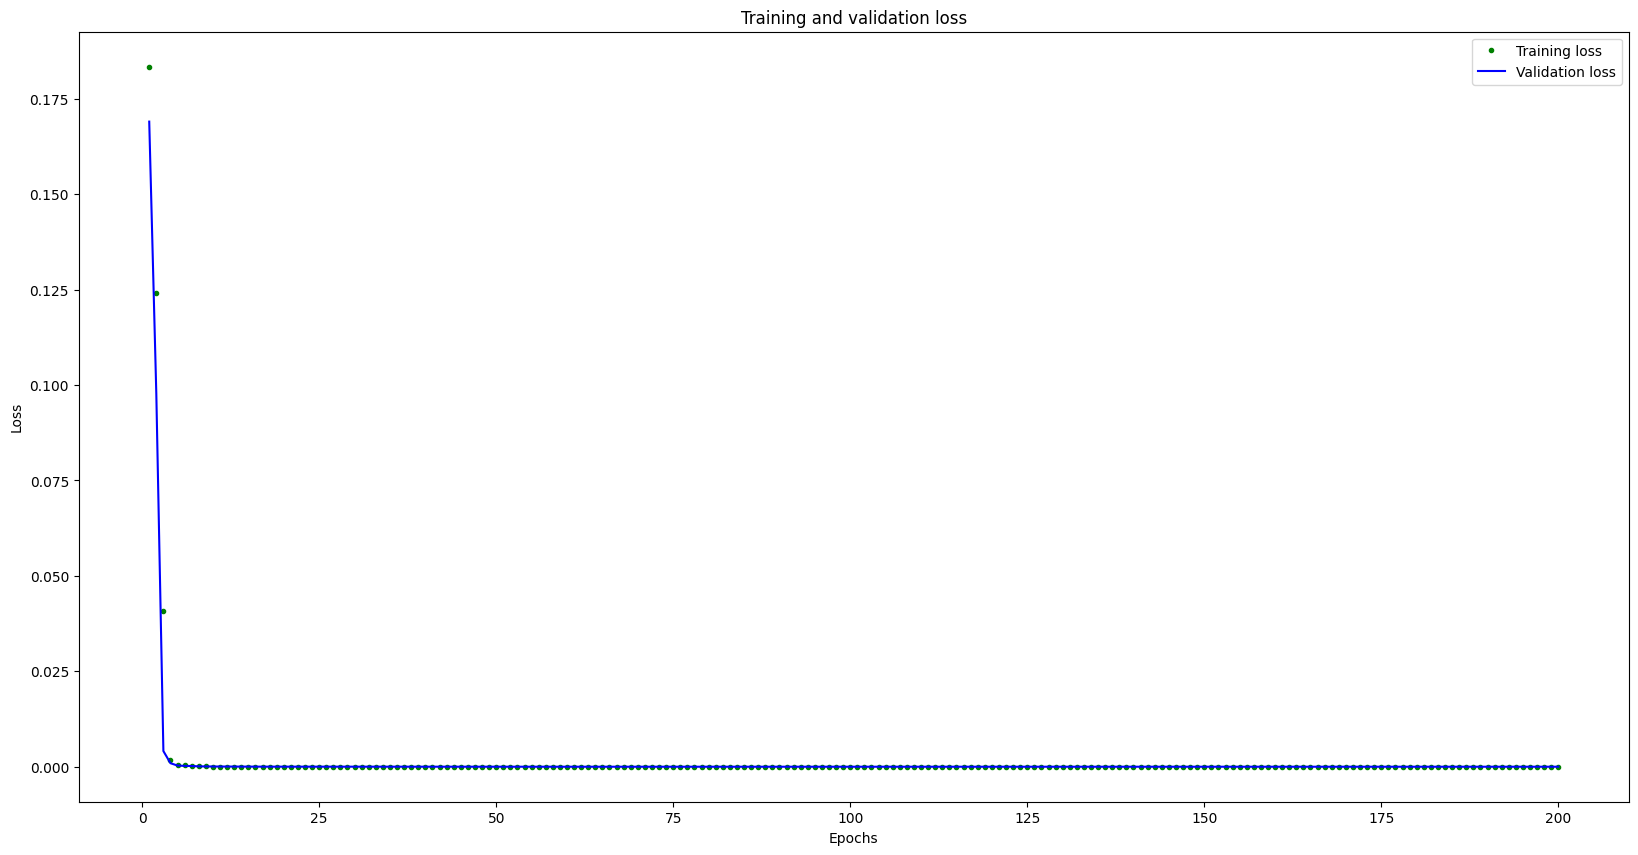

In [127]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

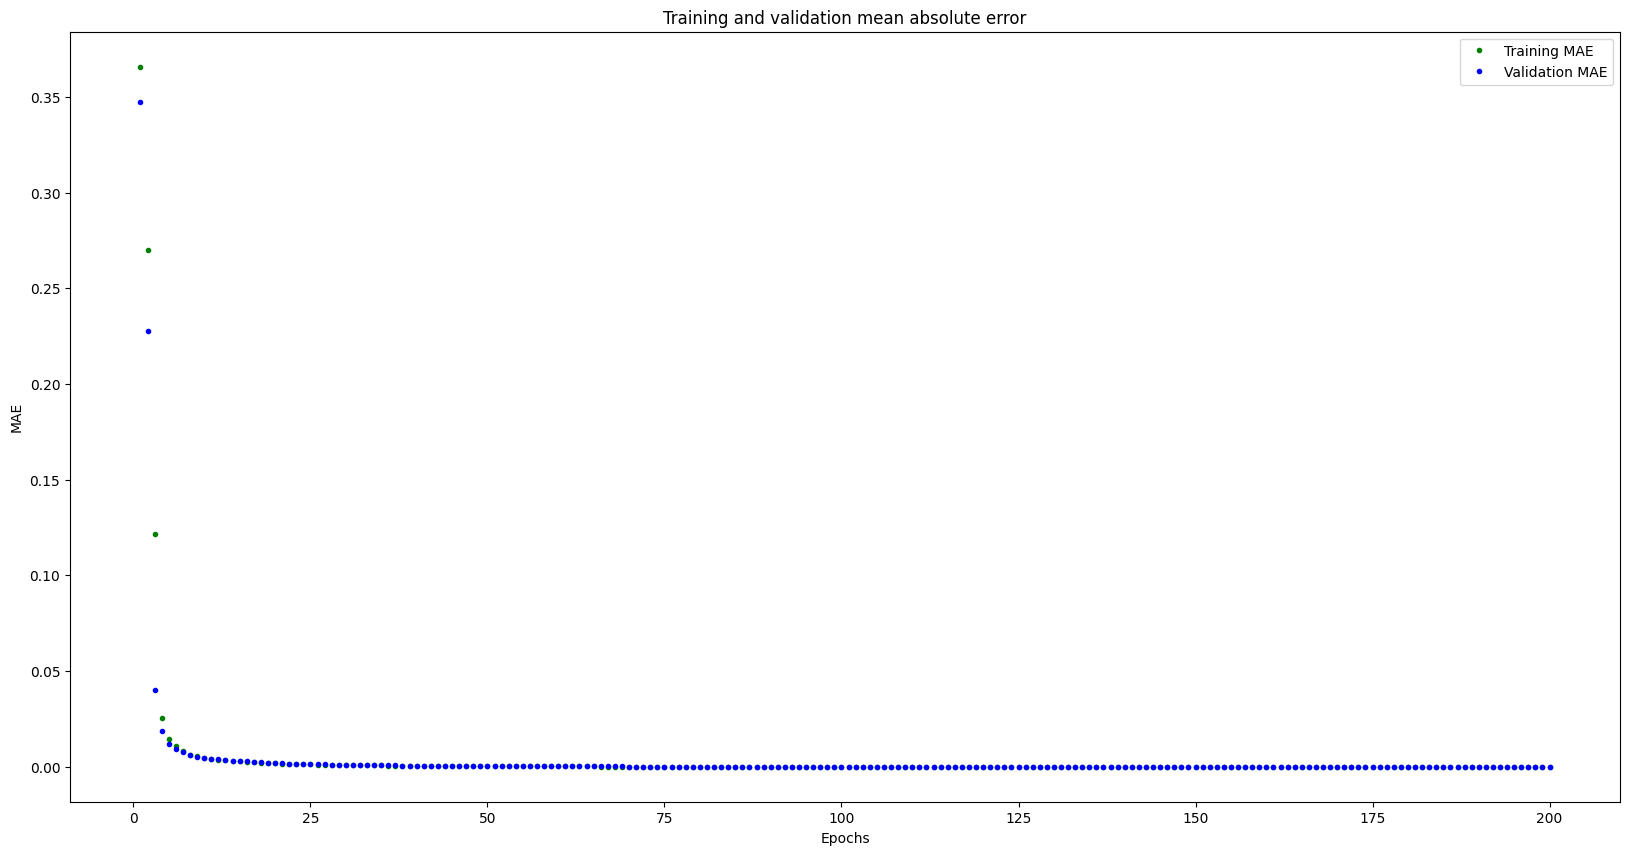

In [128]:
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']
plt.plot(epochs[:], mae[:], 'g.', label='Training MAE')
plt.plot(epochs[:], val_mae[:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [129]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
# print("predictions =\n", np.round(predictions, decimals=3))
# print("actual =\n", outputs_test)


# count the total number of accurate predictions

correct = 0
for i in range(len(predictions)):
    if np.argmax(predictions[i]) == np.argmax(outputs_test[i]):
        correct += 1

print(f"Accuracy: {(correct / len(predictions))*100}%")
print((1/NUM_GESTURES)*100)

2/2 [==============================] - 0s 5ms/step
Accuracy: 100.0%
25.0


In [136]:
converter_original = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite = converter_original.convert()
open("model.tflite","wb").write(model_tflite)



def representative_dataset_generator():
    for value in inputs_test:
        yield [np.array(value,dtype =np.float32,ndmin=2)]
        
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
        
converter.representative_dataset = representative_dataset_generator

model_tflite_quantized = converter.convert()
open("model_quantized.tflite","wb").write(model_tflite_quantized)


/usr/local/lib/python3.9/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


57728

In [138]:
model_quant_eval = tf.lite.Interpreter('model_quantized.tflite')
model_quant_eval.allocate_tensors()
model_quant_eval_input_index = model_quant_eval.get_input_details()[0]["index"]
model_quant_eval_output_index = model_quant_eval.get_output_details()[0]["index"]
model_quant_eval_predictions = []

for input_value in inputs_test:
  input_value_tensor = tf.convert_to_tensor([input_value], dtype=np.float32)
  model_quant_eval.set_tensor(model_quant_eval_input_index, input_value_tensor)
  model_quant_eval.invoke()
  model_quant_eval_predictions.append(model_quant_eval.get_tensor(model_quant_eval_output_index)[0])

correct = 0
for i in range(len(predictions)):
    if np.argmax(model_quant_eval_predictions[i]) == np.argmax(outputs_test[i]):
        correct += 1

print(f"Accuracy: {correct / len(predictions)}")


Accuracy: 1.0


In [139]:
basic_model_size = os.path.getsize("model.tflite")
print("Model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("model_quantized.tflite")
print("Quantized Model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Model is 215756 bytes
Quantized Model is 57728 bytes
Difference is 158028 bytes


In [140]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [141]:
model_tflite_file = open('model_quantized.tflite','rb')
model_tflite = model_tflite_file.read()
with open('model_quantized.h','w') as file:
    file.write(hex_to_c_array(model_tflite,'model_quantized'))

In [142]:
model_tflite_file = open('model.tflite','rb')
model_tflite = model_tflite_file.read()
with open('model.h','w') as file:
    file.write(hex_to_c_array(model_tflite,'model'))